# Plot timelines of ROH sharing
Plot individuals against their estimated age.
Input: Post-processed .csvs (pandas dfs) with individual ROH statistics and meta information (in particular age)

In [1]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as clb
import matplotlib.colors as cls
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap

import socket
import os as os
import sys as sys
import multiprocessing as mp

### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

### To do lowess smoothing
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

### Additional Imports
sys.path.append("./PackagesSupport/")
from sqrt_scale import SquareRootScale # Import Matplotlib sqrt scale

midway2-0403.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Definie Plotting Function for Timelines

In [13]:
def plot_scatter_by_color(ax, age, roh, colors, labels, s):
    """Split up df per color, used to create legend
    (based on "clst" column)"""
    
    for c in pd.unique(colors):
        idx = (colors == c)
        if c!="silver":
            ax.scatter(age[idx], roh[idx], c=c, edgecolor="k", s=s, 
                   label=labels[idx][0], zorder=1)
        else:   # If default coor don't plot label
            ax.scatter(age[idx], roh[idx], c=c, edgecolor="k", s=s, zorder=5)

def plot_lowess_smoothing(df, cm=4, fs=14, fsl=10, ticks = [3539.39/16, 3539.39/64], 
                          tick_l=["1st C.", "2nd C."], figsize=(14,6), title="", dpi=300, savepath="", 
                          xlim=[], ylim=[], s=40, frac=2/3, cust_c=True, labelpad=10,
                          leg_loc="upper right", ax=0, swap_ax=True, show=True, xticks=False):
    """Plot Lowess Smoothing of ROH vrs Age.
    df: Which Dataframe to use [standard pp format]
    cm: Length of blocks to plot
    savepath: If given save figure to there
    tot_l: Total length of accessible Chromosome [in cM]
    frac: Fraction Parameter to use for Lowess Smoothing.
    leg_loc: Where to plot the Legend. If no string given do not plot at all
    swap_ax: Whether to swap left/right tick axis
    fs/fsl: Fontsize Axis / Fontsize Legend/Cousin Ticks"""
    
    ### Extract what to plot from dataframe
    df = df.sort_values(by="age", ascending=False) # Sort by age from old to young
    age,roh,labels = df["age"].values, df[f"sum_roh>{cm}"].values+0.1, df["clst"].values
    c = "b" 
    if cust_c==True:
        c = df["color"].values
    
    ### Make new axis if none given
    if ax==0:  
        plt.figure(figsize=figsize)
        ax = plt.gca()
    
    plot_scatter_by_color(ax, age, roh, colors=c, labels=labels, s=s)
    
    if frac>0.0:
        z = lowess_sqrt(age, roh, frac=frac)
        plt.plot(z[:,0], z[:,1], "k-", label=r"Lowess Smoothing ($\sqrt{x}$)", 
                 lw=2.5, zorder=1)
        
    if len(xlim)>0:
        ax.set_xlim(xlim)
    if not xticks:
        ax.set_xticks([])
        
    if len(ylim)>0:
        ax.set_ylim(ylim)
        
    if len(leg_loc)>0:
        ax.legend(loc=leg_loc, fontsize=fsl)
    if len(title)>0:
        ax.set_title(title, fontsize=fs)

    ### Horizontal Lines
    for i in range(len(ticks)):
        ax.axhline(ticks[i], color="gray", lw=0.5, ls="--")
        ax.text(0, ticks[i], tick_l[i], fontsize=fsl, ha="right", va="bottom", zorder=0)
        
    ax.invert_xaxis()
    ax.set_yscale('squareroot')
    
    ### Make left/right ticks (after Plotting!):
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yscale('squareroot')
    
    if swap_ax:
        ax, ax2 = ax2, ax # Hack to swap left and right
    
    ax2.set_yticks([])
    ax.tick_params(axis='both', which='major', labelsize=fsl)
    #ax2.tick_params(axis='y', direction='in', labelsize=fsl, pad=5)

    # Do the original axis
    ax.set_xlabel("Age BP [years]", fontsize=fs)
    ax.set_ylabel(f"Sum ROH >{cm} cM [cM]", fontsize=fs, rotation=270, labelpad=labelpad)

        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=dpi)
        print(f"Saved to {savepath}")
    
    if show:
        plt.show()
    
def lowess_sqrt(x, y, frac=2/3):
    """Do a Lowess fitting on the sqrt.
    frac: parameter for lowess smoothing"""
    y=np.sqrt(y)
    z = lowess(y, x, frac=frac)
    z[:,1]=z[:,1]**2
    return z

####################################################
##### Helper Functions to split up Dataframes

def extract_df_geo(df, lat0, lat1, lon0, lon1):
    """Extract Dataframe df from Sub Data frame based on coordinates
    lat0,lat1: Min and Max Lat. Equ. for lon0,lon1"""
    lat_okay = (df["lat"]>lat0) & (df["lat"]<lat1)
    lon_okay = (df["lon"]>lon0) & (df["lon"]<lon1)
    df_s = df[lat_okay & lon_okay]
    return df_s

def extract_df_age(df, age0, age1=1e6):
    """Extract Dataframe based on age.
    df: Input Dataframe; age0 and age1 min and max age"""
    age_okay = (df["age"]>=age0) & (df["age"]<=age1)
    df = df[age_okay]
    return df

def give_df_clsts(df, search=[], col="pop"):
    """Return sub dataframe within df
    where in col one of search strings (list of string)"""
    if len(search)>0:
        idx = df[col].str.contains('|'.join(search)) # Find
        df = df[idx]
    else:
        df=df[0:0]
    return df

def extract_sub_df_geo_kw(df, lat0, lat1, lon0, lon1, keywords=[]):
    """Extract Dataframe df from Sub Data frame based on coordinates
    AND from keywords
    lat0,lat1: Min and Max Lat. Equ. for lon0,lon1"""
    df1 = extract_df_geo(df, lat0, lat1, lon0, lon1).copy()  # Make a new Copy. America
    df2 = give_df_clsts(df, search=keywords) 
    df_m = pd.concat([df1, df2]).drop_duplicates().reset_index(drop=True)
    print(f"Found {len(df_m)} Individuals; {len(df1)} from Geography")
    return df_m

# Functions to pre-process regional dataframes

In [3]:
def pre_process_roman_df(df, age_error=0, remove_sard=False):
    """Preprocess and return roman df and adds colors"""
    color_dict = {"Medieval/EarlyModern":"yellow", "Imperial":"red", "Iron/Republic":"magenta", "LateAntiquity":"orange", 
              "Copper Age":"aquamarine", "Neolithic":"dodgerblue", "Mesolithic":"purple", "(not included in analyses)":"gray"}
    df["color"] = df["clst"].map(color_dict)
    if age_error>0:
        df["age"]+= np.random.random(len(df))*age_error - age_error/2
        
    ### Remove the 
    if remove_sard:
        del_idx = (df["clst"] == "(not included in analyses)")
        df = df[~del_idx]
    return df


def pre_process_iberia_df(df, age_error=0):
    """Preprocess and return roman df and adds colors"""
    df["color"]="silver"

    ### WHG Coloring
    hg_terms = ["HG", "Meso", "ElMiron"]
    idx = df["clst"].str.contains('|'.join(hg_terms))
    df.loc[idx, "color"]="purple"
    df.loc[idx, "clst"]="Mesolithic"
    
    ### EN Coloring
    en_terms = ["Iberia_EN"]
    idx = df["clst"].str.contains('|'.join(en_terms))
    df.loc[idx,"color"]="blue"
    df.loc[idx,"clst"]="Early Neolithic"
    
    ### Middle Late Neoltihic
    mn_terms = ["MN", "MLN", "MN", "LN"]
    idx = df["clst"].str.contains('|'.join(mn_terms))
    df.loc[idx,"color"]="lightblue"
    df.loc[idx,"clst"]="Middle/Late Neolithic"
    
    ### Muslim Burials
    en_terms = ["SE_Iberia_c.10-16CE"]
    idx = df["clst"].str.contains('|'.join(en_terms))
    df.loc[idx,"color"]="red"
    df.loc[idx,"clst"]="Muslim Period"
    
    if age_error>0:
        df["age"]+= np.random.random(len(df)) * age_error - age_error/2      
    return df

def pre_process_europe_df(df, age_error=0):
    """Preprocess and return roman df and adds colors"""
    ### WHG Coloring
    hg_terms = ["HG", "Meso", "ElMiron", "Iron Gates", "Loschbour"]
    idx = ((df["clst"].str.contains('|'.join(hg_terms))) | (df["age"]>10500)) & (df["age"]>5000)
    df.loc[idx,"color"]="purple"
    df.loc[idx,"clst"]="Mesolithic"
    
    ### EN Coloring
    en_terms = ["EN", "Early Neol", "Neolithic", "Cardial", "MN", "LN", "MLN"]
    idx = df["clst"].str.contains('|'.join(en_terms)) & (df["age"]>5500)
    df.loc[idx,"color"] = "aqua"
    df.loc[idx,"clst"] = "Neolithic"
    
    ### Middle Late Neoltihic
    #mn_terms = ["MN", "MLN", "MN", "LN", "Early Neolithic"]
    #idx = df["clst"].str.contains('|'.join(mn_terms))
    #df.loc[idx,"color"]="lightblue"
    #df.loc[idx,"clst"]="Farmers"
    
    ### Antatolia Farmers
    en_terms = ["Anatolia_N"]
    idx = df["clst"].str.contains('|'.join(en_terms))
    df.loc[idx,"color"]="blue"
    df.loc[idx,"clst"]="Anatolia Farmers"
    
    en_terms = ["Canaanite"]
    idx = df["clst"].str.contains('|'.join(en_terms))
    df.loc[idx,"color"]="red"
    df.loc[idx,"clst"]="Canaanite"
    
    en_terms = ["Sar-Nur"]
    idx = df["clst"].str.contains('|'.join(en_terms))
    df.loc[idx,"color"]="red"
    df.loc[idx,"clst"]="Nuragic"
    
    if age_error>0:
        df["age"]+= np.random.random(len(df)) * age_error - age_error/2
        
    return df

### Plot Antonio

Saved to ./figures/manuscript/supplement/timelines/antonio.pdf


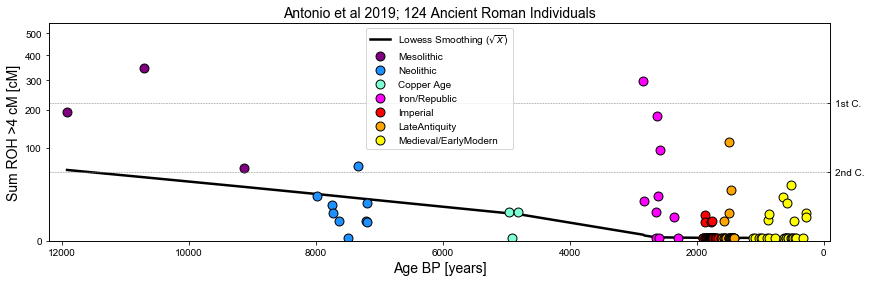

In [105]:
df1 = pd.read_csv("./Empirical/1240k/Antonio/combined_roh05.csv", sep="\t")
df1 = pre_process_roman_df(df1, age_error=100, remove_sard=True)
plot_lowess_smoothing(df1, cm=4, ylim=[0,550], xlim=[-100, 12200], title=f"Antonio et al 2019; {len(df1)} Ancient Roman Individuals",
                      lowess=True, frac=0.8, figsize=(14,4), s=80, savepath="./figures/manuscript/supplement/timelines/antonio.pdf",
                      leg_loc="upper center")

# Do the Plot for South America [Paper]

Saved to ./figures/manuscript/timelines/south_america.pdf


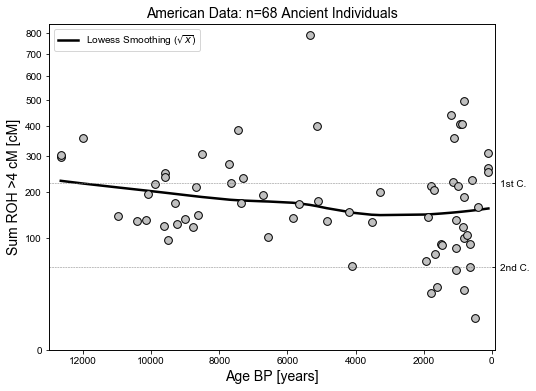

In [95]:
df_e = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", sep="\t")
df_e["color"] = "silver"
df_e["clst"] = "Ancient Individual"
df_a = extract_df_geo(df_e, -60, 55, -130, -30).copy()  # Make a new Copy. America

plot_lowess_smoothing(df_a, cm=4, xlim=[-100,13000], ylim=[0,850], title=f"American Data: n={len(df_a)} Ancient Individuals",
                      lowess=True, frac=0.7, figsize=(8,6), s=60, savepath="./figures/manuscript/timelines/south_america.pdf", 
                      leg_loc="upper left")

# Plot European Data [Paper]

Saved to ./figures/manuscript/timelines/europe.pdf


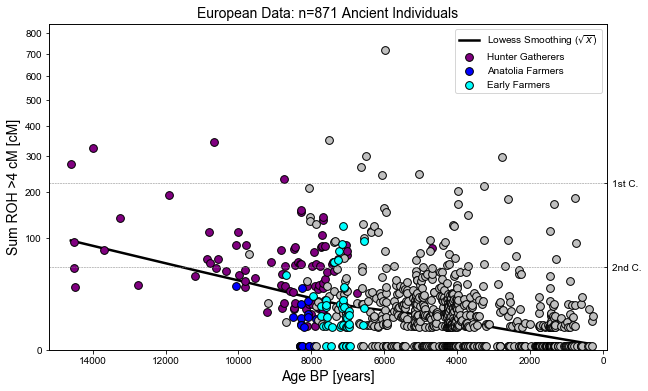

In [113]:
df_e = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", sep="\t")
df_ib = pd.read_csv("./Empirical/Eigenstrat/Olalde19/combined_roh05.csv", sep="\t")
df_it = pd.read_csv("./Empirical/1240k/Antonio/combined_roh05.csv", sep="\t")
df_c = pd.concat([df_e, df_ib, df_it], ignore_index=True, sort=True).sort_values(by="sum_roh>4", ascending=False)

df_c["color"]="silver"
#df_c["clst"]="Ancient Individual"
df_c = pre_process_europe_df(df_c, age_error=50)

df_c = extract_df_age(df_c, 0, 18000)
df_euro = extract_df_geo(df_c, 29, 62, -10, 45).copy()  # Make a new Copy. EUrope

plot_lowess_smoothing(df_euro, cm=4, xlim=[-100,15200], ylim=[0,850], 
                      title=f"European Data: n={len(df_euro)} Ancient Individuals",
                      lowess=True, frac=0.7, figsize=(10,6), s=60, 
                      savepath="./figures/manuscript/timelines/europe.pdf")

# Do Plot Iberia with Olalde 2019

In [6]:
df_1 = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", sep="\t")
df_2 = pd.read_csv("./Empirical/Eigenstrat/Olalde19/combined_roh05.csv", sep="\t")
df_c = pd.concat([df_1, df_2], ignore_index=True, sort=True).sort_values(by="sum_roh>4", ascending=False)
df_c = pre_process_iberia_df(df_c, age_error=50)
df_e = extract_sub_df_geo_kw(df_c,  35.95, 44, -10, 4, keywords = ["Iberia", "Portugal", "Spain"])

Found 136 Individuals; 118 from Geography


Found 134 Individuals; 116 from Geography
Saved to ./figures/manuscript/timelines/iberia.pdf


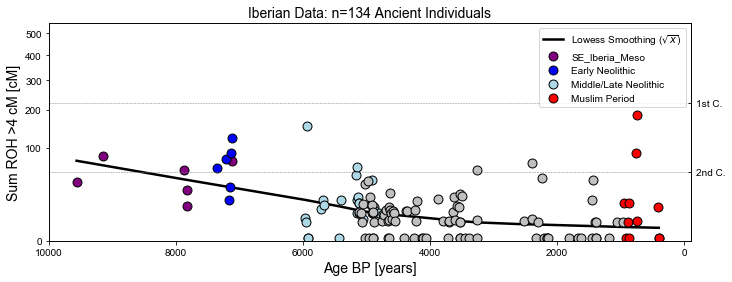

In [7]:
df_e = extract_df_age(df_e, 0, 15000)
df_e = extract_sub_df_geo_kw(df_e,  35.95, 44, -10, 4, keywords=["Iberia", "Portugal", "Spain"])

### Preprocess the Iberian data
plot_lowess_smoothing(df_e, cm=4, xlim=[-100, 10000], ylim=[0,550], title=f"Iberian Data: n={len(df_e)} Ancient Individuals",
                      lowess=True, frac=0.8, figsize=(11.5, 4), s=80, savepath="./figures/manuscript/timelines/iberia.pdf", 
                      leg_loc="upper right")

# Some summary Statistics relevant for the Paper

In [134]:
en_terms = ["Anatolia Farmers"]
idx = df_euro["clst"].str.contains('|'.join(en_terms))
df_anatolia = df_euro[idx]
zero_roh = np.sum(df_anatolia["n_roh>4"]==0)
print(f"Anatolia Farmers: {zero_roh} / {len(df_anatolia)} have 0 ROH > 4 cM")

Anatolia Farmers: 11 / 23 have 0 ROH > 4 cM


### Do European data with high consanguinity

In [141]:
### Fraction of whole European dataset with ROH > 150 cM
zero_roh = np.sum(df_euro["sum_roh>4"]>150)
print(f"Hunter Gatherers: {zero_roh} / {len(df_euro)} have 150 cM ROH > 4 cM")

### Same for WHG
en_terms = ["Hunter Gatherers"]
idx = df_euro["clst"].str.contains('|'.join(en_terms))
df_anatolia = df_euro[idx]
zero_roh = np.sum(df_anatolia["sum_roh>4"]>150)
print(f"Hunter Gatherers: {zero_roh} / {len(df_anatolia)}  have 150 cM ROH > 4 cM")

Hunter Gatherers: 23 / 871 have 150 cM ROH > 4 cM
Hunter Gatherers: 7 / 87  have 150 cM ROH > 4 cM


# Plot both map and ROH timeline

### Function to plot the map

In [5]:
def plot_map_ax(df, ax, crs=[30, 60, -10, 40], s=40, vrange=[0, 7500], cmap="viridis_r", map_title="", title_loc=(0.1,0.1),
                fs_label=14, figsize=(12,11), states=False, annotate=False, fs_labels=14, ew=0.5, y_off=1, title="", 
                vrange_a=[], mm=3.1, hspace=0.02, fs=18, col_cont = "#d9d9d9", col_lake = "#d9d9d9", show=True): 
    """Plot a continent, based on coordinates in df
    df: Pandas Datframe with lat lon column
    crs: [4], Corners of plot (lat and then lon)
    vrange: Normalization range for color [cM]
    shiftlong: Add to longitude (in cases for map on South America)
    vrange_a: The Age Range to Plot"""
    lon, lat = df["lon"].values, df["lat"].values
    colors = df["age"]  ### Plot based on sum roh
    cmap = cm.get_cmap(cmap)
    norm = plt.Normalize(vrange[0], vrange[1]) 
    
    m = Basemap(projection='merc', llcrnrlat=crs[0], urcrnrlat=crs[1],\
                llcrnrlon=crs[2], urcrnrlon=crs[3], resolution='i', ax=ax)  # mill

    m.fillcontinents(color=col_cont, zorder=0, lake_color=col_lake)
    #m.etopo(scale=0.5, alpha=0.4)  # Topological Map
    m.drawcoastlines(color='gray', zorder=0)
    m.drawcountries(color="dimgray")
    if states:
        m.drawstates()
        
    coords = np.array([m(lon[i],lat[i]) for i in range(len(lon))])
    x,y = np.array(coords[:,0]), np.array(coords[:,1])
    ax.scatter(x, y, c=colors, ec="k", s=s, lw=ew, cmap=cmap, norm=norm, zorder=3)
    
    if annotate:
        for i, txt in enumerate(df["iid"]):
            ax.text(x[i], y[i]+y_off, txt, fontsize=fs_labels, zorder=1, ha="center", clip_on=True)

    if len(title)>0:
        ax.set_title(title, fontsize=fs_labels)
    if len(map_title)>0:
        ax.text(title_loc[0], title_loc[1], map_title,
                fontsize=fs, transform=ax.transAxes, ha="left", va="bottom")
        
    if show:
        plt.show()
    
def plot_colorbar_age(ax, fs_label, cmap, vrange, labelpad=10, invert=True):
    """Code for plotting a colorbar of age onto axis Object"""
    cmap = cm.get_cmap(cmap)
    norm = plt.Normalize(vrange[0], vrange[1]) 
    cb1 = clb.ColorbarBase(ax, cmap=cmap,
                           norm=norm, orientation='horizontal') # For the /1e3 format
    cb1.ax.tick_params(axis='x', direction='in', labelsize=fs_label)
    ax.set_xlabel('Age [years BP]', fontsize=fs_label, rotation=0, labelpad=labelpad)
    ax.set_xlim(vrange)
    if invert:
        ax.invert_xaxis()
    
###########################################################
### Plot Map AND timeline in one plot

def plot_map_time(df, figsize=(20,4), width_ratios=[1,10], height_ratios=[20,1], wspace=0.02, hspace=0.03,
                  title_tl = "", s_tl=80,  x_lim_tl=[-100, 10000], y_lim_tl=[0,550],
                  leg_loc_tl="upper center", frac=0.8, cm=4, fs=10, fsl=10,
                  vrange_m=[0, 7500], cmap_m="viridis_r", crs_m=[30, 60, -10, 40], lbl_pad_age=10,
                  lbl_pad_time=5, map_title="", title_loc=(0.1,0.1), savepath=""):
    """Plot Map (Left) and Timeline (Right)
    df: Dataframe with input data on individual block sharing: Columns for sum>cm, age, and color
    _tl Arguments: Arguments for the Timeline.
    cm: Minimum Block length shown
    frac: Fraction for Lowess Smoothin (if 0 no lowess smoothing shown)
    savepath: Where to save (if given)
    cmap_m, vrange_m: Color Map (Keyword) and Range for Map Plots
    crs_m: Corners for the Map (Lat0, Lat1, Lon0, Lon1)-Vector"""
    
    ### Set Up the outer Figure Layout
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 2, width_ratios=width_ratios, height_ratios=height_ratios, figure=fig)
    ax_map = plt.subplot(gs[:,0])    # The left subplot (Timeline)
    ax_map_cb = plt.subplot(gs[1,1])
    ax_time = plt.subplot(gs[0,1])   # The right subplot (Timeline)
    gs.update(wspace=wspace, hspace=hspace) # set the spacing between axes
    
    ### Plot the Timeline (right)
    plot_lowess_smoothing(df, cm=cm, xlim=x_lim_tl, ylim=y_lim_tl, title=title_tl, fs=fs, fsl=fsl,
                          frac=frac, s=s_tl, leg_loc=leg_loc_tl, ax=ax_time, labelpad=lbl_pad_time, show=False)
    ### Plot the Map (left)
    plot_map_ax(df, ax=ax_map, crs=crs_m, cmap=cmap_m, vrange=vrange_m, map_title=map_title, show=False, 
                fs=fs, title_loc=title_loc, s=s_tl)
    ### Plot the Colorbar for the Map
    plot_colorbar_age(ax_map_cb, fs_label=fsl, cmap=cmap_m, vrange=x_lim_tl, labelpad=lbl_pad_age)
    ### Save
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved to {savepath}")
    plt.show()

## Do various European Populations
Instructions: 
- Load the functions at top and just above.
- Then run the first cell that extracts all SA individuals.
- Then all panels that geographically subset

In [5]:
df_eu = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", sep="\t")
df_eu = extract_sub_df_geo_kw(df_eu, 28, 63, -11, 38)
idx_flip = df_eu["iid"]=="I7554"
df_eu.loc[idx_flip, "lon"] = -df_eu.loc[idx_flip, "lon"]  # Flip Wrong Latitude Atlantic
idx_del = df_eu["iid"].str.contains("Loschbour")
df_eu = df_eu[~idx_del]

Found 1098 Individuals; 664 from Geography


/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


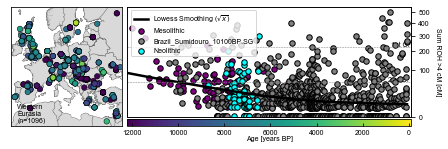

In [510]:
df_1["color"] = "gray"
df_1 = extract_df_age(df_1, 0, 15000)
df_1 = pre_process_europe_df(df_eu)

plot_map_time(df_1, figsize=(7.2 , 2.2), crs_m=[28, 63, -11, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=30, 
              x_lim_tl=[-100, 12200], y_lim_tl=[0,550], lbl_pad_age=0, lbl_pad_time=11, fsl=7, fs=7, leg_loc_tl="upper left",
              map_title=f"Western\nEurasia\n(n={len(df_1)})", title_loc=(0.06,0.02))

### Italy (Antonio et al. 2019)

Saved to ./figures/manuscript/timelines/eu_panel/roman.pdf


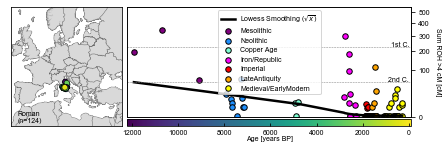

In [7]:
df1 = pd.read_csv("./Empirical/1240k/Antonio/combined_roh05.csv", sep="\t")
df1 = pre_process_roman_df(df1, age_error=100, remove_sard=True)

plot_map_time(df1, figsize=(7.2 , 2.2), crs_m=[28, 63, -11, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=30, 
              x_lim_tl=[-100, 12200], y_lim_tl=[0,550], lbl_pad_age=0, lbl_pad_time=11, fsl=7, fs=7, leg_loc_tl="upper center",
              map_title=f"Roman\n(n={len(df1)})", title_loc=(0.06,0.02),
              savepath="./figures/manuscript/timelines/eu_panel/roman.pdf")

### Iberia (Olalde et al. 2019)

In [8]:
df_1 = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", sep="\t")
df_2 = pd.read_csv("./Empirical/Eigenstrat/Olalde19/combined_roh05.csv", sep="\t")
df_c = pd.concat([df_1, df_2], ignore_index=True, sort=True).sort_values(by="sum_roh>4", ascending=False)
df_c = pre_process_iberia_df(df_c, age_error=50)
df_e = extract_sub_df_geo_kw(df_c,  35.95, 44, -10, 4, keywords = ["Iberia", "Portugal", "Spain"])
df_ib = extract_df_age(df_e, 0, 15000)

Found 136 Individuals; 120 from Geography


Saved to ./figures/manuscript/timelines/eu_panel/iberia.pdf


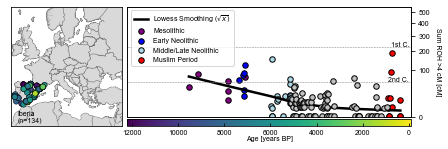

In [9]:
plot_map_time(df_ib, figsize=(7.2 , 2.2), crs_m=[28, 63, -11, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=30, 
              x_lim_tl=[-100, 12200], y_lim_tl=[0,550], lbl_pad_age=0, lbl_pad_time=11, fsl=7, fs=7, leg_loc_tl="upper left",
              map_title=f"Iberia\n(n={len(df_ib)})", title_loc=(0.06,0.02),
              savepath="./figures/manuscript/timelines/eu_panel/iberia.pdf")

### Do the Balkans

In [10]:
df_1 = extract_sub_df_geo_kw(df_eu,  42.2, 46.9, 13.05, 23.9, keywords = ["Balkans", "Serbia", "Hungary"])
df_1["color"]="silver"
df_1 = pre_process_europe_df(df_1)
df_1 = extract_df_age(df_1, 0, 15000)

Found 159 Individuals; 102 from Geography


Saved to ./figures/manuscript/timelines/eu_panel/balkans.pdf


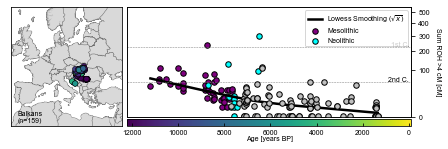

In [11]:
plot_map_time(df_1, figsize=(7.2 , 2.2), crs_m=[28, 63, -11, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=30, 
              x_lim_tl=[-100, 12200], y_lim_tl=[0,550], lbl_pad_age=0, lbl_pad_time=11, fsl=7, fs=7, leg_loc_tl="upper right",
              map_title=f"Balkans\n(n={len(df_1)})", title_loc=(0.06,0.02),
              savepath="./figures/manuscript/timelines/eu_panel/balkans.pdf")

### Do Anatolia / Greece

In [12]:
df_1 = extract_sub_df_geo_kw(df_eu,  36.3, 41, 18, 40.4, keywords = ["Anatolia", "Greece"])
df_1["color"]="silver"
df_1 = pre_process_europe_df(df_1)
df_1 = extract_df_age(df_1, 0, 15000)

Found 51 Individuals; 43 from Geography


Saved to ./figures/manuscript/timelines/eu_panel/aegan.pdf


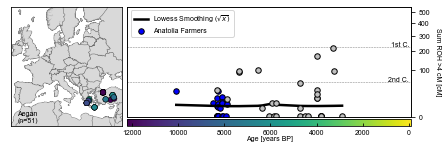

In [13]:
plot_map_time(df_1, figsize=(7.2 , 2.2), crs_m=[28, 63, -11, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=30, 
              x_lim_tl=[-100, 12200], y_lim_tl=[0,550], lbl_pad_age=0, lbl_pad_time=11, fsl=7, fs=7, leg_loc_tl="upper left",
              map_title=f"Aegan\n(n={len(df_1)})", title_loc=(0.06,0.02),
              savepath="./figures/manuscript/timelines/eu_panel/aegan.pdf")

### Central Europe

Found 138 Individuals; 138 from Geography
Saved to ./figures/manuscript/timelines/eu_panel/ce.pdf


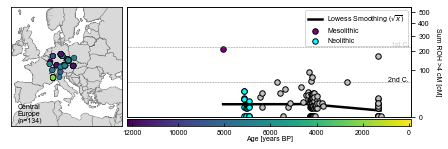

In [14]:
df_1 = extract_sub_df_geo_kw(df_eu,  45, 52, 5, 16.9, keywords = ["Austria"])
df_1["color"]="silver"
df_1 = pre_process_europe_df(df_1)
df_1 = extract_df_age(df_1, 0, 13000)

plot_map_time(df_1, figsize=(7.2 , 2.2), crs_m=[28, 63, -11, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=30, 
              x_lim_tl=[-100, 12200], y_lim_tl=[0,550], lbl_pad_age=0, lbl_pad_time=11, fsl=7, fs=7, leg_loc_tl="upper right",
              map_title=f"Central\nEurope\n(n={len(df_1)})", title_loc=(0.06,0.02), frac=0.9,
              savepath="./figures/manuscript/timelines/eu_panel/ce.pdf")

### Britain

Found 131 Individuals; 114 from Geography
Saved to ./figures/manuscript/timelines/eu_panel/britain.pdf


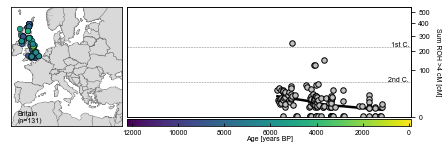

In [15]:
df_1 = extract_sub_df_geo_kw(df_eu, 49, 60, -12, 3, keywords = ["Britain", "Scot", "Wales", "England", "Orkney"])
df_1["color"]="silver"
df_1 = pre_process_europe_df(df_1)
df_1 = extract_df_age(df_1, 0, 15000)

plot_map_time(df_1, figsize=(7.2 , 2.2), crs_m=[28, 63, -11, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=30, 
              x_lim_tl=[-100, 12200], y_lim_tl=[0,550], lbl_pad_age=0, lbl_pad_time=11, fsl=7, fs=7, leg_loc_tl="",
              map_title=f"Britain\n(n={len(df_1)})", title_loc=(0.06,0.02),
              savepath="./figures/manuscript/timelines/eu_panel/britain.pdf")

### Baltic

Found 47 Individuals; 47 from Geography
Saved to ./figures/manuscript/timelines/eu_panel/baltic.pdf


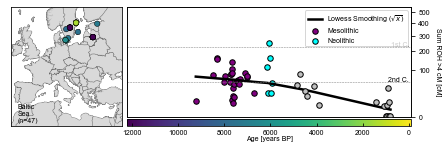

In [64]:
df_1 = extract_sub_df_geo_kw(df_eu, 53, 67, 7, 35, keywords = ["Baltic"])
df_1["color"]="silver"
df_1 = pre_process_europe_df(df_1, age_error=50)
df_1 = extract_df_age(df_1, 0, 15000)

plot_map_time(df_1, figsize=(7.2 , 2.2), crs_m=[28, 63, -11, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=30, 
              x_lim_tl=[-100, 12200], y_lim_tl=[0,550], lbl_pad_age=0, lbl_pad_time=11, fsl=7, fs=7, leg_loc_tl="upper right",
              map_title=f"Baltic\nSea\n(n={len(df_1)})", title_loc=(0.06,0.02),
              savepath="./figures/manuscript/timelines/eu_panel/baltic.pdf") # ./figures/manuscript/timelines/eu_panel/sardinia.pdf

# Sardinia

Found 40 Individuals; 40 from Geography
Saved to ./figures/manuscript/timelines/eu_panel/sardinia.pdf


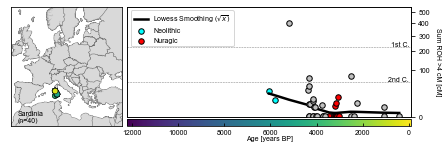

In [44]:
df_m = pd.read_csv("./Empirical/1240k/MarcusAncs/combined_roh05.csv", sep="\t")
df_m["color"]="silver"
df_m = pre_process_europe_df(df_m)
df_m = extract_df_age(df_m, 0,15000)
df_1 = extract_sub_df_geo_kw(df_m, 38.7, 41.3, 8.0, 9.9, keywords=["Sar-"])

plot_map_time(df_1, figsize=(7.2 , 2.2), crs_m=[28, 63, -11, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=30, 
              x_lim_tl=[-100, 12200], y_lim_tl=[0,550], lbl_pad_age=0, lbl_pad_time=11, fsl=7, fs=7, leg_loc_tl="upper left",
              map_title=f"Sardinia\n(n={len(df_1)})", title_loc=(0.06,0.02),
              savepath="./figures/manuscript/timelines/eu_panel/sardinia.pdf")

## Bonus Round

## Levante

Found 22 Individuals; 21 from Geography
Saved to ./figures/manuscript/timelines/eu_panel/levant.pdf


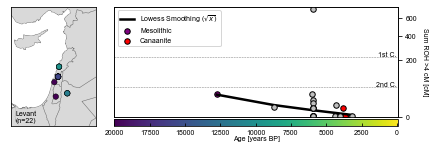

In [36]:
df_1 = extract_sub_df_geo_kw(df_eu, 30, 37, 32, 38, keywords = ["Levant", "Israel", "Canaanite"])
df_1["color"]="silver"
df_1 = pre_process_europe_df(df_1, age_error=50)
df_1 = extract_df_age(df_1, 0, 20000)

plot_map_time(df_1, figsize=(7.2 , 2.2), crs_m=[30, 37, 32, 38], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=30, 
              x_lim_tl=[-100, 20000], y_lim_tl=[0,750], lbl_pad_age=0, lbl_pad_time=11, fsl=7, fs=7, leg_loc_tl="upper left",
              map_title=f"Levant\n(n={len(df_1)})", title_loc=(0.06,0.02), frac=1.0,
              savepath="./figures/manuscript/timelines/eu_panel/levant.pdf")

### Vanuatu

Found 24 Individuals; 24 from Geography
Saved to ./figures/manuscript/timelines/eu_panel/vanuatu.pdf


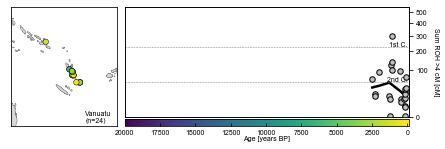

In [63]:
df_w = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", sep="\t")
df_1 = extract_sub_df_geo_kw(df_w, -30, -5, 155, 180, keywords = ["Vanuatu"])
df_1["color"]="silver"
df_1 = pre_process_europe_df(df_1, age_error=50)
df_1 = extract_df_age(df_1, 0, 20000)

plot_map_time(df_1, figsize=(7.2 , 2.2), crs_m=[-30, 0, 152, 180], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=30, 
              x_lim_tl=[-100, 20000], y_lim_tl=[0,550], lbl_pad_age=0, lbl_pad_time=11, fsl=7, fs=7, leg_loc_tl="",
              map_title=f"Vanuatu\n(n={len(df_1)})", title_loc=(0.7, 0.02), frac=1.0,
              savepath="./figures/manuscript/timelines/eu_panel/vanuatu.pdf")

### Eurasian Steppe

Found 203 Individuals; 203 from Geography


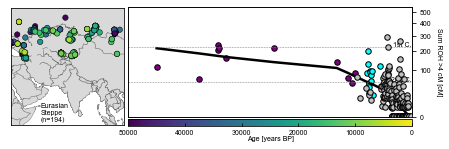

In [64]:
df_w = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", sep="\t")
df_1 = extract_sub_df_geo_kw(df_w, 40, 61, 35, 110, keywords = [])
df_1["color"]="silver"
df_1 = df_1[~df_1["iid"].str.contains("Mezmaiskaya")] # No Neanderthals allowed
df_1 = df_1[~df_1["iid"].str.contains("Ishim_published.DG")] # Duplicate
df_1 = df_1[~df_1["iid"].str.contains("Kostenki14.SG")] # Duplicate
df_1 = pre_process_europe_df(df_1, age_error=50)
df_1 = extract_df_age(df_1, 0, 50000)

plot_map_time(df_1, figsize=(7.2 , 2.2), crs_m=[0, 61, 35, 110], width_ratios=(8, 20), height_ratios=[15, 1], s_tl=30, 
              x_lim_tl=[-100, 50000], y_lim_tl=[0,550], lbl_pad_age=0, lbl_pad_time=11, fsl=7, fs=7, leg_loc_tl="",
              map_title=f"Eurasian\nSteppe\n(n={len(df_1)})", title_loc=(0.26, 0.02), frac=0.9,
              savepath="")  # ./figures/manuscript/timelines/eu_panel/vanuatu.pdf

In [58]:
df_1.sort_values(by="age", ascending=False)

,iid,pop,max_roh,sum_roh>4,n_roh>4,sum_roh>8,n_roh>8,sum_roh>12,n_roh>12,lat,lon,age,study,clst,mean_cov,n_cov_snp,include_alt,color
19,UstIshim_snpAD.DG,Ust_Ishim.DG,15.454399,113.246776,16,48.268392,4,29.996496,2,57.700000,71.100000,45042.037650,Pruefer2017,Mesolithic,42.000000,1062044,1,purple
42,Kostenki14,Russia_Kostenki14,13.498700,64.610824,10,23.102599,2,13.498700,1,51.230000,39.300000,37464.904068,FuNature2016,Mesolithic,16.136000,1095867,1,purple
6,Sunghir2.SG,Russia_Sunghir2.SG,26.426399,231.640181,29,115.524080,8,78.515396,4,56.176111,40.502500,34249.170837,SikoraScience2017,Mesolithic,4.623346,1164216,1,purple
10,Sunghir3.SG,Russia_Sunghir3.SG,15.081108,201.824429,25,124.099524,12,41.111714,3,56.176111,40.502500,34093.001413,SikoraScience2017,Mesolithic,12.034287,1181712,1,purple
9,Sunghir4.SG,Russia_Sunghir4.SG,24.782204,214.967203,25,142.110697,12,60.975104,3,56.176111,40.502500,33988.153375,SikoraScience2017,Mesolithic,4.398612,1160873,1,purple
12,Sunghir1.SG,Russia_Sunghir1.SG,20.875299,158.806409,25,32.136398,2,20.875299,1,56.176111,40.502500,32829.147295,SikoraScience2017,Mesolithic,1.280993,809229,1,purple
8,MA1.SG,Russia_MA1_HG.SG,14.029700,217.874309,34,65.021586,6,27.963895,2,52.900000,103.500000,24306.916345,RaghavanNature2013,Mesolithic,1.206000,820035,1,purple
14,SATP.SG,Georgia_Satsurblia.SG,19.914800,138.288995,20,36.208998,3,19.914800,1,42.380000,42.590000,13237.383374,JonesNatureCommunications2015,Mesolithic,1.191000,816136,1,purple
38,Sidelkino.SG,Russia_Sidelkino_HG.SG,13.486603,68.590815,10,23.264304,2,13.486603,1,54.530000,51.110000,11243.990759,DamgaardScience2018,Mesolithic,2.900000,967604,1,purple
50,I1819,Ukraine_Mesolithic,12.962799,53.797399,7,30.747401,3,12.962799,1,47.434167,35.276389,10662.138018,MathiesonNature2018,Mesolithic,3.435000,813114,1,purple


# South American Populations
Instructions: 
- Load the functions at top and just above.
- Then run the first cell that extracts all SA individuals.
- Then all panels that geographically subset

In [455]:
### Overview
df_e = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", sep="\t")
sa_corners = [-59, 57, -130, -32]
df_e.loc[df_e["iid"]=="Aconcagua.SG", "lat"] = -32.65  # Flip Wrong Latitude (32.64 is in Atlantic)
df_e["color"] = "silver"
df_e["clst"] = "Ancient Individual"
df_e = extract_df_geo(df_e, -60, 55, -130, -30).copy()  # Make a new Copy. America

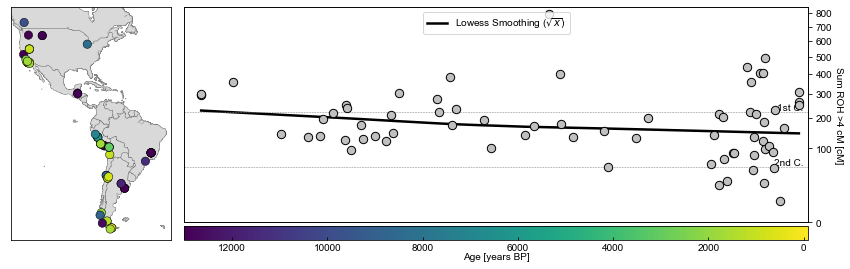

In [292]:
plot_map_time(df_e, figsize=(14.4 , 4.3), crs_m=sa_corners, width_ratios=(5.5, 20), height_ratios=[15, 1],
              x_lim_tl=[-100, 13000], y_lim_tl=[0,850], lbl_pad_age=0, lbl_pad_time=11, frac=1.0, s_tl=70)

Saved to ./figures/manuscript/timelines/sa_panel/fuego.pdf


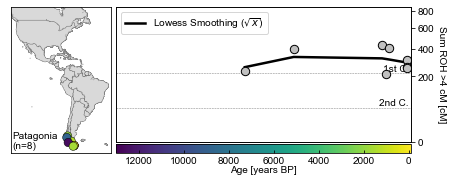

In [420]:
### Tierra del Fuego
df_sa = extract_df_geo(df_e, -60, -41, -130, -30).copy()  # Make a new Copy. America
plot_map_time(df_sa, figsize=(7.2 , 2.7), crs_m=sa_corners, width_ratios=(7, 20), height_ratios=[15, 1],
              wspace=0.02, x_lim_tl=[-100, 13000], y_lim_tl=[0,850], lbl_pad_age=0, lbl_pad_time=11, frac=1.0, leg_loc_tl="upper left",
              map_title=f"Patagonia\n(n={len(df_sa)})", title_loc=(0.02,0.02), s_tl=70,
              savepath="./figures/manuscript/timelines/sa_panel/fuego.pdf")

Saved to ./figures/manuscript/timelines/sa_panel/and.pdf


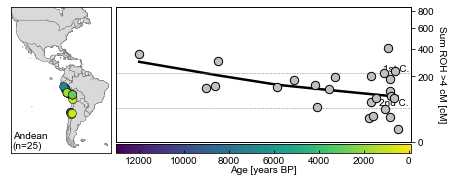

In [328]:
### Plot Andeans
df_sa = extract_df_geo(df_e, -41, 10, -130, -63).copy()  # Make a new Copy. America
plot_map_time(df_sa, figsize=(7.2 , 2.7), crs_m=sa_corners, width_ratios=(7, 20), height_ratios=[15, 1],
              wspace=0.02, x_lim_tl=[-100, 13000], y_lim_tl=[0,850], lbl_pad_age=0, lbl_pad_time=11, frac=1.0, 
              leg_loc_tl="", map_title=f"Andean\n(n={len(df_sa)})", title_loc=(0.02,0.02), s_tl=70,
              savepath="./figures/manuscript/timelines/sa_panel/and.pdf")

Saved to ./figures/manuscript/timelines/sa_panel/pac_nw.pdf


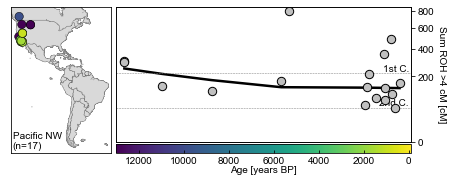

In [329]:
### Pacific NW
df_sa = extract_df_geo(df_e, 30, 55, -130, -95).copy()  # Make a new Copy. America
plot_map_time(df_sa, figsize=(7.2 , 2.7), crs_m=sa_corners, width_ratios=(7, 20), height_ratios=[15, 1],
              wspace=0.02, x_lim_tl=[-100, 13000], y_lim_tl=[0,850], lbl_pad_age=0, lbl_pad_time=11, frac=1.0, 
              leg_loc_tl="", map_title=f"Pacific NW\n(n={len(df_sa)})", title_loc=(0.02,0.02), s_tl=70,
              savepath="./figures/manuscript/timelines/sa_panel/pac_nw.pdf")

Saved to ./figures/manuscript/timelines/sa_panel/atl_coast.pdf


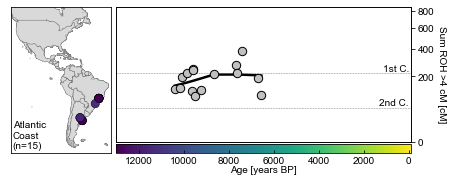

In [330]:
### Atlandic coast
df_sa = extract_df_geo(df_e, -41, 10, -63, -30).copy()  # Make a new Copy. America
plot_map_time(df_sa, figsize=(7.2 , 2.7), crs_m=sa_corners, width_ratios=(7, 20), height_ratios=[15, 1],
              x_lim_tl=[-100, 13000], y_lim_tl=[0,850], lbl_pad_age=0, lbl_pad_time=11, frac=1.0, leg_loc_tl="",
              map_title=f"Atlantic\nCoast\n(n={len(df_sa)})", title_loc=(0.02,0.02), s_tl=70,
              savepath="./figures/manuscript/timelines/sa_panel/atl_coast.pdf")

# Area 51

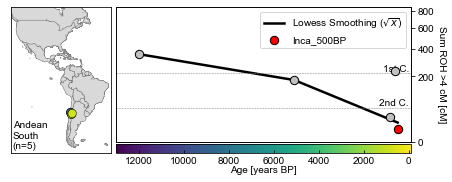

In [434]:
### Plot Andeans
df_sa = extract_df_geo(df_e, -41, -26, -130, -63).copy()  # Make a new Copy. America
df_sa.loc[df_sa["iid"]=="Aconcagua.SG", "color"]="red"  
df_sa.loc[df_sa["iid"]=="Aconcagua.SG", "clst"]="Inca_500BP"  
plot_map_time(df_sa, figsize=(7.2 , 2.7), crs_m=sa_corners, width_ratios=(7, 20), height_ratios=[15, 1],
              wspace=0.02, x_lim_tl=[-100, 13000], y_lim_tl=[0,850], lbl_pad_age=0, lbl_pad_time=11, frac=1.0, 
              leg_loc_tl="upper right", map_title=f"Andean\nSouth\n(n={len(df_sa)})", title_loc=(0.02,0.02), s_tl=70,
              savepath="")

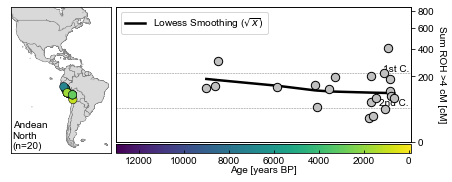

In [429]:
### Plot Andeans
df_sa = extract_df_geo(df_e, -26, 10, -130, -63).copy()  # Make a new Copy. America
plot_map_time(df_sa, figsize=(7.2 , 2.7), crs_m=sa_corners, width_ratios=(7, 20), height_ratios=[15, 1],
              wspace=0.02, x_lim_tl=[-100, 13000], y_lim_tl=[0,850], lbl_pad_age=0, lbl_pad_time=11, frac=1.0, 
              leg_loc_tl="", map_title=f"Andean\nNorth\n(n={len(df_sa)})", title_loc=(0.02,0.02), s_tl=70,
              savepath="")